## Introduction to Text Mining and NLP: Term Paper

---------------------------
Ramón Talvi

David Vallmanya

Irene Villalonga

---------------------------

### 1) WEB SCRAPING

In [ ]:
import praw
import datetime
import pandas as pd
from praw.models import MoreComments

secret_token = ""
client_id = ""
username = ""
password = ""

reddit = praw.Reddit(client_id=client_id,
                     client_secret=secret_token, password=password,
                     user_agent='MyBot/0.0.1', username=username)

limit_submission = 2000
limit_comments = 800

df = pd.DataFrame()

count_posts = 0
count_comments = 0
count_errors = 0

submission = reddit.submission("og731j")

if not submission.stickied:

    count_posts += 1

    p_awards = 0
    for award in submission.all_awardings:
         p_awards += 1

    for i in range(limit_comments+1):

        try:

            if submission.comments[i] == None:
                continue

            if isinstance(submission.comments[i], MoreComments):
                continue

            if submission.comments[i].stickied == False:


                c_author = submission.comments[i].author
                if c_author == None: 
                    c_author = "NA"
                else:
                    c_author = c_author.name

                c_replies = 0
                
                for reply in submission.comments[i].replies:
                    itera +=1 
                    if itera == 50:
                        itera = 0
                        break
                    
                    if reply == None:
                        continue

                    if isinstance(reply, MoreComments):
                        continue
                        
                    c_author = reply.author
                    if c_author == None: 
                        c_author = "NA"
                    else:
                        c_author = c_author.name
                    
                    c_replies += 1
                    df_comment = pd.DataFrame({
                        'post_id': submission.id,
                        'comment_id': reply.id,
                        'subreddit': submission.subreddit.display_name,
                        'post_title': submission.title,
                        'post_ups': submission.ups,
                        'post_upvote_ratio': submission.upvote_ratio,
                        'post_num_comments': submission.num_comments,
                        'post_time': datetime.datetime.fromtimestamp(submission.created_utc),
                        'post_downs': submission.downs,
                        'post_score': submission.score,
                        'post_awards': 0,
                        'comment_awards': 0,
                        'comment_author': c_author,
                        'body': reply.body,
                        'comment_replies': 0,
                        'comment_ups': reply.score,
                        'comment_downs': "NA",
                        'comment_time' : datetime.datetime.fromtimestamp(submission.comments[i].created_utc),
                        'comment_score': reply.score
                    }, index=[count_comments])

                    print("reply")

                    df = pd.concat([df, df_comment])

                c_awards = 0
                for award in submission.comments[i].all_awardings:
                    c_awards += 1


                df_comment = pd.DataFrame({
                    'post_id': submission.id,
                    'comment_id': submission.comments[i].id,
                    'subreddit': submission.subreddit.display_name,
                    'post_title': submission.title,
                    'post_ups': submission.ups,
                    'post_upvote_ratio': submission.upvote_ratio,
                    'post_num_comments': submission.num_comments,
                    'post_time': datetime.datetime.fromtimestamp(submission.created_utc),
                    'post_downs': submission.downs,
                    'post_score': submission.score,
                    'post_awards': p_awards,
                    'comment_awards': c_awards,
                    'comment_author': c_author,
                    'body': submission.comments[i].body,
                    'comment_replies': c_replies,
                    'comment_ups': submission.comments[i].ups,
                    'comment_downs': submission.comments[i].downs,
                    'comment_time' : datetime.datetime.fromtimestamp(submission.comments[i].created_utc),
                    'comment_score': submission.comments[i].score
                }, index=[count_comments])

                df = pd.concat([df, df_comment])

                print("Post: "+str(count_posts) + "    Comment:"+ str(count_comments) + "    Inpost comment:" + str(i))

                count_comments += 1

        except IndexError as e:
            count_errors += 1
            continue

print(count_errors)
df.to_csv("cmv_extract.csv", sep=';')
df

### 2) PRE PROCESSING 
In this section we are going to first load and clean the Data Frame. Then we will carry out the usual steps in Text Mining preprocessing: tokenization, lemmatizing, remove punctuation, unify, remove stopwords. Finally we will obtain the Document Term Matrix. 

#### A) DATA LOADING AND DELAING WITH NA

In [1]:
import os
import pandas as pd

In [2]:
# Load the dataframe
readin = '/run/media/david-vp/davidvp-files/DSMMaster/intro-NLP/reddit-project/'
filename ="cmv_extract.csv"

df = pd.read_csv(os.path.join(readin, filename), sep=';', encoding='utf-8')

#df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       736 non-null    int64  
 1   Unnamed: 0         736 non-null    int64  
 2   post_id            736 non-null    object 
 3   comment_id         736 non-null    object 
 4   subreddit          736 non-null    object 
 5   post_title         736 non-null    object 
 6   post_ups           736 non-null    int64  
 7   post_upvote_ratio  736 non-null    float64
 8   post_num_comments  736 non-null    int64  
 9   post_time          736 non-null    object 
 10  post_text          736 non-null    object 
 11  post_downs         736 non-null    int64  
 12  post_score         736 non-null    int64  
 13  post_awards        736 non-null    int64  
 14  comment_awards     736 non-null    int64  
 15  comment_author     647 non-null    object 
 16  body               736 non

In [3]:
#remove edited part of comments
def remove_edit(text):
    text = text.replace("Edit:", "edit:")
    return text.split("edit:")[0]

df['body'] = df['body'].apply(remove_edit)

In [4]:
#remove NA and deleted
df = df.loc[df['body'] != '[removed]']
df = df.loc[df['body'] != '[deleted]']

df = df.dropna(subset=['body']) 

df = df.reset_index(drop=True) 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       725 non-null    int64  
 1   Unnamed: 0         725 non-null    int64  
 2   post_id            725 non-null    object 
 3   comment_id         725 non-null    object 
 4   subreddit          725 non-null    object 
 5   post_title         725 non-null    object 
 6   post_ups           725 non-null    int64  
 7   post_upvote_ratio  725 non-null    float64
 8   post_num_comments  725 non-null    int64  
 9   post_time          725 non-null    object 
 10  post_text          725 non-null    object 
 11  post_downs         725 non-null    int64  
 12  post_score         725 non-null    int64  
 13  post_awards        725 non-null    int64  
 14  comment_awards     725 non-null    int64  
 15  comment_author     647 non-null    object 
 16  body               725 non

In [5]:
df['body'][17]

'First Step justice reform\n\nmore money to historically black universities than any other president\n\nIsrael- UAE agreement\n\nSerbia-Kosovo agreement\n\nUS energy independence\n\nstarted no new wars for first time in decades\n\ndrawing down troops from Iraq and Afghanistan\n\nOpportunity zones - have brought in over $70B\n\n Moved U.S. Embassy to Jerusalem \n\nbuilding border wall\n\n U.S.-Mexico Trade Deal to replace NAFTA \n\nUS-Mexico-Canada agreement\n\nStarting to put China in their place\n\nexposed media as the scum they are'

Note that from a unique post title: " Donald Trump has not made a single lasting positive impact on the USA during his term as president" we have extracted 725 user's opinions. 

#### B) VISUALIZING REDDIT PROMPT TITLE AND TWO RANDOM ARTICLES

In [6]:
title = "\033[1mPost Title:\033[0m\n"
text1 = "\033[1mText 1:\033[0m\n"
text2 = "\033[1mText 2:\033[0m\n"

print(title, df.post_title[0])
print("\n")
print(text1, df.body[3])
print("\n")
print(text2, df.body[5])


Post Title:
 CMV: Donald Trump has not made a single lasting positive impact on the USA during his term as president.


Text 1:
 I can't believe I'm doing this, but they say you should argue in favour of things you disagree with sometimes..... That said, this isn't easy.

1- He's donated his entire presidential salary to a variety of causes every year since his inauguration- VAs, education services and plenty more.

2- He convinced the Mexican government to modernise its labour laws as part of a trade treaty. Mexicans can now unionise properly! Could be argued that this doesn't affect the US, but I think that a happier and more well-protected workforce in a trade partner country will have benefits.

3- He started positive reforms to the prison system with the First Step act.

4- he killed (not personally) Abu Bakr al-Baghdadi.

Honourable mention: SPACE FORCE. Worth it for the name alone, and he gave the rest of the world a good laugh.

Of course, none of this makes up for completely t

#### C) TOWARDS DOCUMENT TERM MATRIX

In [7]:
import re
import nltk           

# Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)
        
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
                stems.append(" ")
    return "".join(stems)

In [8]:
# stop words
stop_words = set(stopwords.words('english')) 
my_stopwords = ['com', 'reddit', 'http', 'wiki', 'www', 'im', 'trump', 'lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

df['body'] = df['body'].apply(remove_stopwords)


# lemmatizing / stemming
mod=2 #=1 means stemming, =2 means lemmatizing, =0 just lowercase

text_preproc = (
    df.body
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

df_proc = df
df_proc["text_preproc"]=text_preproc

# again stopwords
df['text_preproc'] = df['text_preproc'].apply(remove_stopwords)

100%|████████████████████████████████| 725/725 [00:01<00:00, 616.92it/s]


In [9]:
for article in df.text_preproc[:1]:
    print(article)

signing right try legislation allowing gravely ill patient access experimental drug


In [10]:
Texts = df_proc.text_preproc.tolist()

#stopwords to remove after tokenization
for text in Texts:
    remove_stopwords(text)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Without tf-idf 
# cv = CountVectorizer(ngram_range = (1,2))
# cv.fit(Texts)
# vectorized_text=cv.transform(Texts)
# names=np.array(cv.get_feature_names())
# print("The dimensions of DT matrix are", vectorized_text.shape)

# With tf-idf 

from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(ngram_range = (1,2), norm=None)
cv.fit(Texts)
vectorized_text=cv.transform(Texts)
vectorized_text=vectorized_text.todense()
print("The document term matrix has size", vectorized_text.shape)

The document term matrix has size (725, 21670)


In [12]:
#dtm = pd.DataFrame.sparse.from_spmatrix(vectorized_text)


In [13]:
import seaborn as sns
import pandas as pd

# Heat matrix from Document Term Matrix
#sns.heatmap(dtm.iloc[:50, :50], cmap='YlGnBu')

### 2) SENTIMENT ANALYSIS PER DOCUMENT

In [14]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# instructions
# pip install spacytextblob
# python3 -m textblob.download_corpora
# python3 -m spacy download en_core_web_sm
# pip install spacytextblob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

texts = df['body']
polarities = []
subjectivities = []

for text in texts:
    doc = nlp(text)
    polarity = doc._.blob.polarity
    polarities.append(polarity)
    subjectivity = doc._.blob.subjectivity
    subjectivities.append(subjectivity)

df['sentiment'] = polarities
df['subjectivity'] = subjectivities

df.iloc[:5, -2:]


2023-03-03 19:43:05.062537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 19:43:05.899579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-03 19:43:05.899680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-03-03 19:43:05.899691: W tensorflow/compiler/tf2tensorrt/utils/py_uti

,sentiment,subjectivity
0,-0.200000,0.700000
1,-0.102083,0.585417
2,0.008691,0.452398
3,0.145221,0.311480
4,0.018601,0.343460


In [15]:
#normalize polarities to [0,1] range
polarities = [(polarity + 1) / 2 for polarity in polarities]
polarities_df = pd.DataFrame(polarities)
polarities_df = polarities_df.rename(columns={0: 'polaritites'})

polarities_df.describe()

,polaritites
count,725.000000
mean,0.516816
std,0.127505
min,0.000000
25%,0.472403
50%,0.500000
75%,0.578333
max,1.000000


In [16]:
for i in range(5, 8):
    print(f"\033[1mDocument {i}:\033[0m {df.body[i]}")
    polarities_ = polarities_df.iloc[i].tolist()
    print(f"\033[1mTopic sentiment (polarity):\033[0m {polarities_[-1]}")
    print()


Document 5: fully funded Land Water Conservation Fund perpetuity, funded nearly necessary backlog repair work national parks. Great American Outdoors Act. more, believe disproves claim.
Topic sentiment (polarity): 0.6625

Document 6: difference comes defence spending Europe, slowly climbing upwards 1991. Now, whether beneficial subjective, qualifies successfully achieving political goal. Regards
Topic sentiment (polarity): 0.575

Document 7: huge positive impact USA presidency given truth parents tell kids, namely want- United States. frankly usually joke, know, serious truth it. thoughts America. perspectives young involved. happen believe difference, certainly allows big difference. Now, Trump, around fit traditional political mold, (IMO least) qualified job, lowers bar. That's bad generally, maybe case makes kid "hey, maybe chance, necessarily Harvard grad war hero tough president", maybe kid turns fantastic president. Giving fight begins chance horrible thing. shows truly president

### 3) EMOTION ANALYSIS 

In [19]:
from nrclex import NRCLex

nrc_score = NRCLex("I'm angry!")
emotion = nrc_score.affect_frequencies

texts = df['body']
emotions = []

for text in texts:
    nrc_score = NRCLex(text)
    emotion = nrc_score.affect_frequencies
    emotions.append(emotion)

emotions_df = pd.DataFrame(emotions, columns=['fear', 'anger', 'anticip', 'trust', 'surprise','positive','negative','sadness','disgust','joy'])

emotions_text = emotions_df.copy()
emotions_text['text'] = df['body']
emotions_text['preproc'] = df['text_preproc']
emotions_text['score'] = df['comment_score']
emotions_text['sentiment'] = df['sentiment']

emotions_text.head()

,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,text,preproc,score,sentiment
0,0.200000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,"signing ""right-to-try"" legislation, allowing g...",signing right try legislation allowing gravely...,1646,-0.200000
1,0.058824,0.000000,0.0,0.176471,0.000000,0.294118,0.235294,0.000000,0.058824,0.058824,posted - important accomplishment keeping fore...,posted important accomplishment keeping foreig...,604,-0.102083
2,0.153846,0.076923,0.0,0.000000,0.000000,0.384615,0.230769,0.153846,0.000000,0.000000,Doubling standard deduction taxes absolutely n...,doubling standard deduction tax absolutely net...,1654,0.008691
3,0.074074,0.111111,0.0,0.222222,0.037037,0.185185,0.148148,0.037037,0.000000,0.111111,"can't believe I'm this, argue favour things di...",believe argue favour disagree sometimes easy d...,6714,0.145221
4,0.089286,0.075000,0.0,0.121429,0.028571,0.200000,0.164286,0.089286,0.042857,0.089286,lowered unemployment record lows 2019. high pe...,lowered unemployment record low high percentag...,1826,0.018601


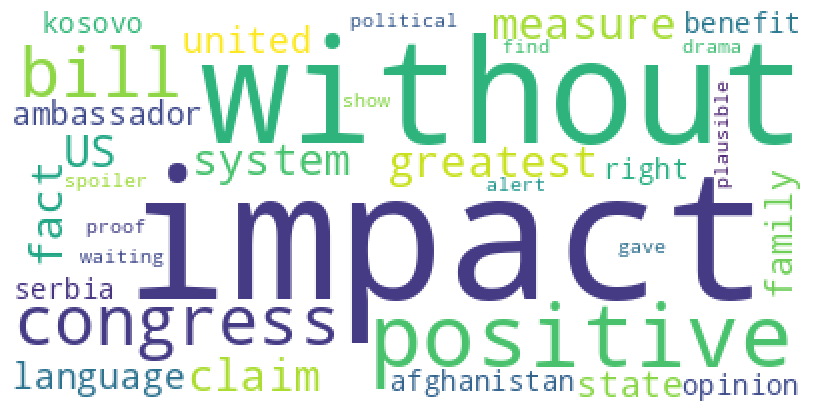

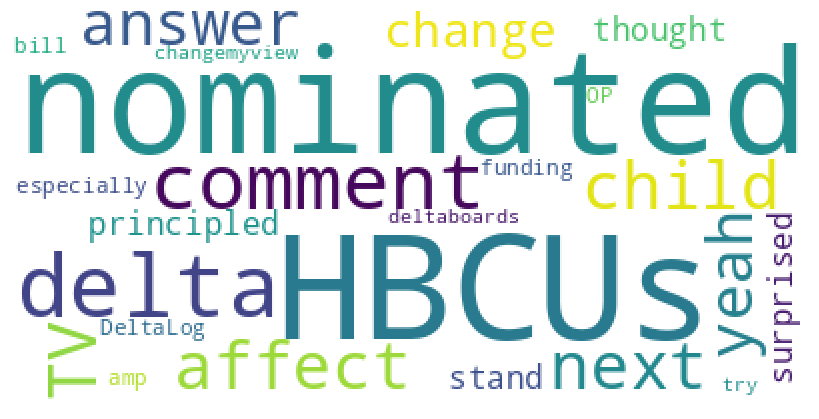

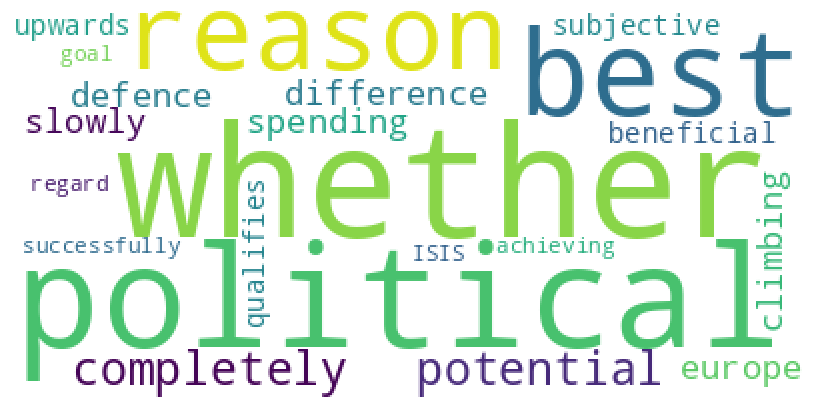

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(background_color='white', min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Get top 10 documents with highest trust score
top_trust = emotions_text.nlargest(15, 'trust')

# Concatenate text of top 10 trust documents into one string
trust_text = " ".join(top_trust['preproc'])

# Get top 10 documents with highest surprise score
top_surprise = emotions_text.nlargest(15, 'surprise')

# Concatenate text of top 10 surprise documents into one string
surprise_text = " ".join(top_surprise['preproc'])

# Get top 10 documents with highest negative score
top_negative = emotions_text.nlargest(15, 'positive')

# Concatenate text of top 10 negative documents into one string
negative_text = " ".join(top_negative['preproc'])

# Generate wordcloud for top 10 trust documents
generate_wordcloud(trust_text)

# Generate wordcloud for top 10 surprise documents
generate_wordcloud(surprise_text)

# Generate wordcloud for top 10 negative documents
generate_wordcloud(negative_text)


In [21]:
sorted_emotions = emotions_text.sort_values('positive',ascending=False)
anger_sentiment = sorted_emotions[['positive', 'sentiment']]
anger_sentiment.head()


,positive,sentiment
508,1.0,0.000000
550,1.0,0.000000
588,1.0,0.000000
170,1.0,0.096591
481,1.0,-0.050000


In [22]:
sorted_emotions = emotions_text.sort_values('negative',ascending=False)
anger_sentiment = sorted_emotions[['negative', 'sentiment']]
anger_sentiment.head()

,negative,sentiment
472,1.0,0.00
673,1.0,-0.25
171,1.0,-0.25
529,1.0,0.50
414,1.0,-0.28


In [23]:
for i in range(9,10):
    text = df['body'][i]
    nrc_score = NRCLex(text)
    emotion = nrc_score.affect_frequencies
    print(f"\033[1mDocument {i}:\033[0m {text}")
    print("\033[1mEmotion proportions:\033[0m")
    print(emotions_df.iloc[i].rename(lambda x: '\033[1m'+x+'\033[0m'))
    print()


Document 9: sole positive turn blind eye China. motivations center, CCP tyrannical regime deprives basic liberty human rights systematically destroying economies countries dumping goods less cost destroy local industry addicted artificially cheap goods. It’s opium. mention fentanyl export. regime bit deadly Hitler’s Germany realization. mindset Chamberlain (just Europe away peace prosperity; vs let Hong Kong’s freedom erode, Taiwan’s claim independence unrecognized, away South China Sea). piss poor job alone approach. critical start standing China. It’s pretty clear Trump’s motives aren’t centered though idolizes Putin Russia, subvert thuggish corrupt cleptocracy could. former leaders refused stand CCP. change Trumps presidency likely positive forward.
Emotion proportions:
fear        0.103448
anger       0.068966
anticip     0.000000
trust       0.103448
surprise    0.034483
positive    0.206897
negative    0.155172
sadness     0.086207
disgust     0.068966
joy         0.086207
Name: 

### 4) TOWARDS RANDOM FOREST MODEL: A DESCRIPTIVE ANALYSIS

#### A) TOP/BOTTOM SCORE DOCUMENTS AND EMOTION PROPORTION

In [24]:
df_sorted = emotions_text.sort_values(by=['score'], ascending=False)

In [25]:
df_sorted.head()

,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,text,preproc,score,sentiment
3,0.074074,0.111111,0.0,0.222222,0.037037,0.185185,0.148148,0.037037,0.000000,0.111111,"can't believe I'm this, argue favour things di...",believe argue favour disagree sometimes easy d...,6714,0.145221
4,0.089286,0.075000,0.0,0.121429,0.028571,0.200000,0.164286,0.089286,0.042857,0.089286,lowered unemployment record lows 2019. high pe...,lowered unemployment record low high percentag...,1826,0.018601
2,0.153846,0.076923,0.0,0.000000,0.000000,0.384615,0.230769,0.153846,0.000000,0.000000,Doubling standard deduction taxes absolutely n...,doubling standard deduction tax absolutely net...,1654,0.008691
0,0.200000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,"signing ""right-to-try"" legislation, allowing g...",signing right try legislation allowing gravely...,1646,-0.200000
5,0.000000,0.000000,0.0,0.400000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,fully funded Land Water Conservation Fund perp...,fully funded land water conservation fund perp...,881,0.325000


In [26]:
emotions_df = emotions_df.drop([ 2,   6,  23, 469, 513, 420, 475, 594, 700, 131,  66, 519, 507,27, 693,  15, 115, 402,  76,  18, 149, 482,   9, 349, 369, 562, 627, 106,  14,  28])
y = df['comment_score']
y = y.drop([ 2,   6,  23, 469, 513, 420, 475, 594, 700, 131,  66, 519, 507, 27, 693,  15, 115, 402,  76,  18, 149, 482,   9, 349, 369, 562,627, 106,  14,  28])

In [27]:
# Top Text with highest score
top_5_texts = df_sorted.head(5)['text'].tolist()
top_5_scores = df_sorted.head(5)['score'].tolist()

for i, text in enumerate(top_5_texts):
    print('\033[1m' + text + '\033[0m')
    print(f'Score: \033[1m{top_5_scores[i]}\033[0m')
    print('-------------')


can't believe I'm this, argue favour things disagree sometimes..... said, easy. 1- He's donated entire presidential salary variety causes inauguration- VAs, education services plenty more. 2- convinced Mexican government modernise labour laws part trade treaty. Mexicans unionise properly! argued affect US, happier well-protected workforce trade partner country benefits. 3- started positive reforms prison system Step act. 4- killed (not personally) Abu Bakr al-Baghdadi. Honourable mention: SPACE FORCE. Worth name alone, gave laugh. course, none makes completely trashing (ahem) formerly positive international reputation US, go. **
Score: 6714
-------------
lowered unemployment record lows 2019. high percentage American's better financially president, according official studies. factually job openings unemployed. wages gone up. African-American unemployment recently achieved lowest recorded. Hispanic-American unemployment lowest recorded. Asian-American unemployment recently achieved lowe

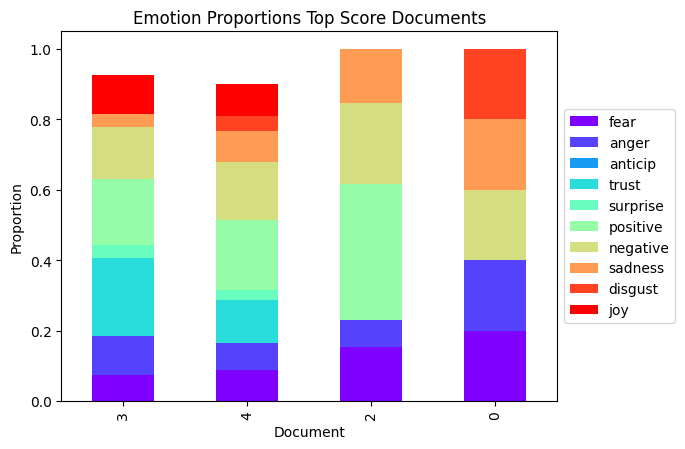

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a color map with shades of blue
cmap = plt.cm.get_cmap('rainbow', len(df.columns))

# Create a DataFrame with the stacked bar chart data
top_5_score = df_sorted.iloc[0:4,0:11]

# Create a stacked bar chart
top_5_score.plot(kind='bar', stacked=True, cmap=cmap)

# Add labels and legend
plt.title('Emotion Proportions Top Score Documents')
plt.xlabel('Document')
plt.ylabel('Proportion')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


In [29]:
# Top Text with lowest score
bottom_5_texts = df_sorted.tail(5)['text'].tolist()

for i, score in zip(bottom_5_texts, df_sorted.tail(5)['score']):
    print(f"\033[1m{i}\033[0m")
    print('-------------')
    print(f"Score: \033[1m{score}\033[0m\n")



Comedy. (admittedly short) politics meme took power. top Brexit handled, ESPECIALLY entrance Boris Johnson Prime Minter, gotta alive! SURELY, disagree, you?
-------------
Score: -6

Yes has. shown Congress cares corporations 1%
-------------
Score: -7

-Raised awareness around racism, white supremacy, police brutality. -Exposed flaws American “Democracy” using power executive branch steamroll two branches -Help expose GOP cult cares retaining power -Expose significant population thinks authoritarianism right USA It’s pretty big list goes on, US showing us change country
-------------
Score: -7

broken clock right twice day. Incompetence lead positivity, especially checks balance system. depends deem "positive". Positive conservative negative you. example, Trump's tenure spent putting conservative judges court system. conservative, positive thing.
-------------
Score: -10

He's helped us truth Republicans, they're scumbag racist liars mind child rape. goes Christians, used accused Chris

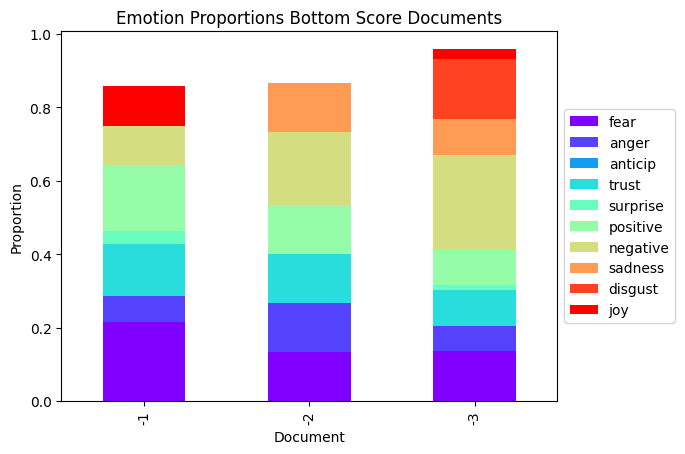

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a color map with shades of blue
cmap = plt.cm.get_cmap('rainbow', len(df.columns))

# Create a DataFrame with the stacked bar chart data
top_5_score = df_sorted.iloc[722:726,0:11]

# Create a stacked bar chart
top_5_score.plot(kind='bar', stacked=True, cmap=cmap)

# Add labels and legend
plt.title('Emotion Proportions Bottom Score Documents')
plt.xlabel('Document')
plt.ylabel('Proportion')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([0, 1, 2], ["-1", "-2", "-3"])

# Show the plot
plt.show()

#### B) EVOLUTION OF TOPIC PROPORTION PER SCORE

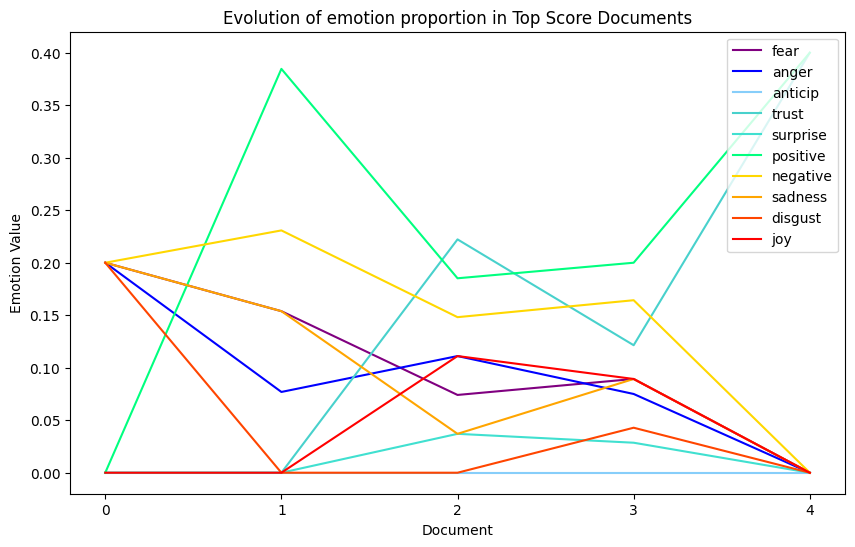

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


lp = df_sorted.iloc[0:5,0:10]
import matplotlib.pyplot as plt

# Sort the data frame by index and select the top 3 rows and all columns
df_sorted1 = lp.sort_index().iloc[0:5, 0:10]

# Define a list of colors to use for each emotion
colors = ['purple','blue','lightskyblue','mediumturquoise',  'turquoise', 'springgreen',  'gold', 'orange', 'orangered', 'red']

# Reset the index of the data frame
lp_reset = df_sorted1.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
# Create a line plot for each emotion column, plotting documents in the desired order
for i, emotion in enumerate(lp_reset.columns[1:]):
    plt.plot(lp_reset.index, lp_reset[emotion], color=colors[i], label=emotion)

# Add a legend in the top right corner
plt.title('Evolution of emotion proportion in Top Score Documents')
plt.legend(loc='upper right')

# Set the x-axis ticks to the document order
plt.xticks(lp_reset.index)

# Add axis labels
plt.ylabel('Emotion Value')
plt.xlabel('Document')

# Display the plot
plt.show()



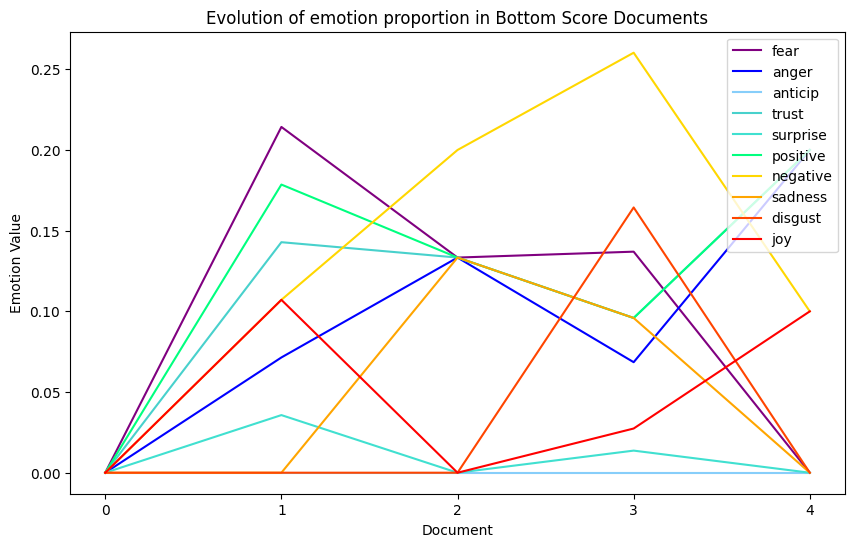

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


lp2 = df_sorted.iloc[-5:,0:10]
import matplotlib.pyplot as plt

# Sort the data frame by index and select the top 3 rows and all columns
df_sorted2 = lp2.sort_index().iloc[0:5, 0:10]

# Define a list of colors to use for each emotion
colors = ['purple','blue','lightskyblue','mediumturquoise',  'turquoise', 'springgreen',  'gold', 'orange', 'orangered', 'red']

# Reset the index of the data frame
lp_reset = df_sorted2.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
# Create a line plot for each emotion column, plotting documents in the desired order
for i, emotion in enumerate(lp_reset.columns[1:]):
    plt.plot(lp_reset.index, lp_reset[emotion], color=colors[i], label=emotion)

# Add a legend in the top right corner
plt.legend(loc='upper right')

# Set the x-axis ticks to the document order
plt.xticks(lp_reset.index)

plt.title('Evolution of emotion proportion in Bottom Score Documents')
# Add axis labels
plt.ylabel('Emotion Value')
plt.xlabel('Document')

# Display the plot
plt.show()

##  5) Baseline Model


Here we make a document term matrix with the 500 most used terms and using a random forest regressor we do a regression using comment_score as the output variable and we also obtain the permutated feature importance to see the effect of the most used terms with the score.

In [17]:
# get the most frequent terms from the vectorized_text
vocab = {v: k for k, v in cv.vocabulary_.items()}
sum_words = vectorized_text.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for idx, word in vocab.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
most_used_words = [x[0] for x in words_freq[:500]]  # change to a different number if desired
#most_used_words = words_freq

cv_most_used = CountVectorizer(vocabulary=most_used_words)

vectorized_text_most_used = cv_most_used.fit_transform(Texts)

Scores =  df['comment_score']

df_most_used_terms = pd.DataFrame(vectorized_text_most_used.todense(), columns=most_used_words)

Now we do the RandomForestRegression with very bad results, it doesn't seem like any terms classify the score well, unlike when we used the emotional variables which were able to identify important features,

Fitting 2 folds for each of 108 candidates, totalling 216 fits


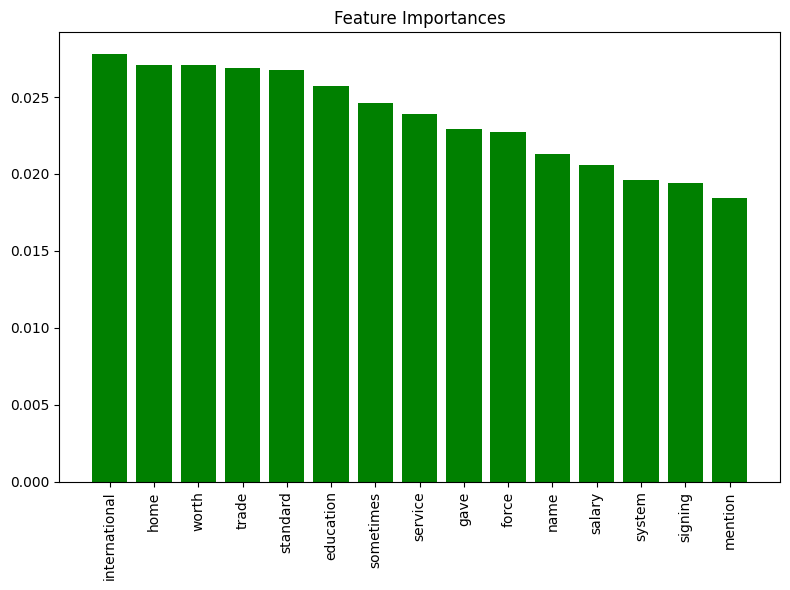

MAE (train): 25.781785276119543
MAE (test): 33.5213187818302


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vectorized_text_most_used, Scores, test_size=0.1, random_state=42)

# define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 6],
    'min_samples_leaf': [1,2,3],
    'max_features': [15, 20]
}

# initialize random forest regressor
rf = RandomForestRegressor(random_state=42)

# perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1,scoring ='neg_mean_absolute_error',verbose=3)

# fit the grid search to the training data
grid_search.fit(X_train, y_train)

# get best hyperparameters
best_params = grid_search.best_params_

# initialize random forest regressor with best hyperparameters
rf_model = RandomForestRegressor(**best_params, random_state=42)

# Fit the model with the training data
rf_model.fit(X_train, y_train)

# Get the feature importances and corresponding feature names
importances = rf_model.feature_importances_
feature_names = most_used_words

# Sort feature importances in descending order
importances_abs_noperm = np.abs(importances)
indices = importances_abs_noperm.argsort()[::-1]
indices = indices[0:15]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")

# Assign colors to the bars based on importance
for i in range(len(indices)):
    if importances_abs_noperm[indices[i]] < -0.05:
        bar_color = 'purple'
    elif importances_abs_noperm[indices[i]] > -0.05:
        bar_color = 'green'
    else:
        bar_color = 'yellow'
        
    plt.bar(i, importances_abs_noperm[indices[i]], color=bar_color)
    
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Predict the comment score for the test data
y_pred = rf_model.predict(X_test)

# Compute the mean squared error of the model on the training and testing data
train_mae = mean_absolute_error(y_train, rf_model.predict(X_train))
test_mae = mean_absolute_error(y_test, y_pred)
print("MAE (train):", train_mae)
print("MAE (test):",test_mae)

In [19]:
from prettytable import PrettyTable

# Define the column names and add them to the table
table = PrettyTable()
table.field_names = ["MAE (train)", "MAE (test)"]

# Add the row values to the table, rounding each value to 2 decimal places
table.add_row([round(train_mae, 2), round(test_mae, 2)])

# Print the table
print(table)

+-------------+------------+
| MAE (train) | MAE (test) |
+-------------+------------+
|    25.78    |   33.52    |
+-------------+------------+


In [20]:
pd.DataFrame(Scores.describe())

,comment_score
count,725.000000
mean,22.707586
std,276.450884
min,-18.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6714.000000


In [21]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(y_train, rf.predict(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(y_train, rf.predict(X_train))
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)


Now we obtain the feature importances to see if any particular term may be connected to the score,

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get the feature importances and corresponding feature names
importances = permutation_importances(rf_model, df_most_used_terms, Scores, mean_absolute_error)
importances_noabs_perm = importances
importances = np.abs(importances)
importances= importances / np.sum(importances)
feature_names = df_most_used_terms.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
indices = indices[0:15]
indices_noabs = importances_noabs_perm.argsort()[::-1]



/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/david-vp/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has

We plot the results, we see that there's no meaningful term that helps classify the score. Our results are cleary less meaningful than using the emotion variables,

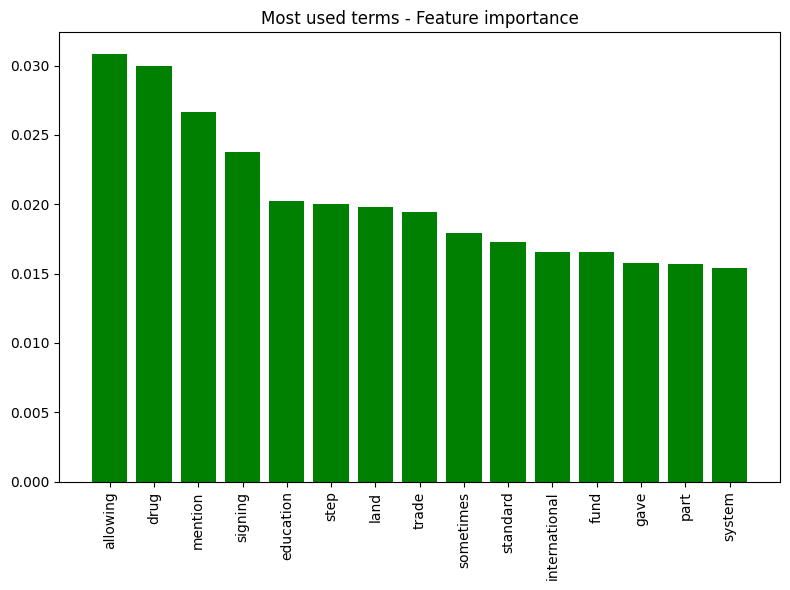

In [35]:
# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Most used terms - Feature importance")

for i in range(len(indices)):
    
    if indices_noabs[i]< -0.05:
        bar_color = 'purple'
    elif indices_noabs[i] > -0.05:
        bar_color = 'green'
    else:
        bar_color = 'yellow'
        
    plt.bar(i, importances[indices[i]], color=bar_color)

plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


### 6) RANDOM FOREST MODEL

In [221]:
# # Create a DataFrame with predicted and actual values
# p = pd.DataFrame({
#     'predicted': rf_model.predict(X_train),
#     'actual': y_train
# })

# # Compute absolute difference between predicted and actual values
# p['difference'] = abs(p['predicted'] - p['actual'])

# # Sort the DataFrame by difference in descending order
# p_sorted = p.sort_values('difference', ascending=False)

# # Get the rows with the biggest difference
# biggest_diff_rows = p_sorted.head(30)

# # Get the row indexes with the biggest difference
# biggest_diff_rows_index = p_sorted.iloc[:30].index

# print(biggest_diff_rows_index)

Int64Index([  2,   6,  23, 469, 513, 420, 475, 594, 700, 131,  66, 519, 507,
             27, 693,  15, 115, 402,  76,  18, 149, 482,   9, 349, 369, 562,
            627, 106,  14,  28],
           dtype='int64')


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=-37.861 total time=   1.5s
[CV 1/2] END max_depth=10, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=-38.811 total time=   1.5s


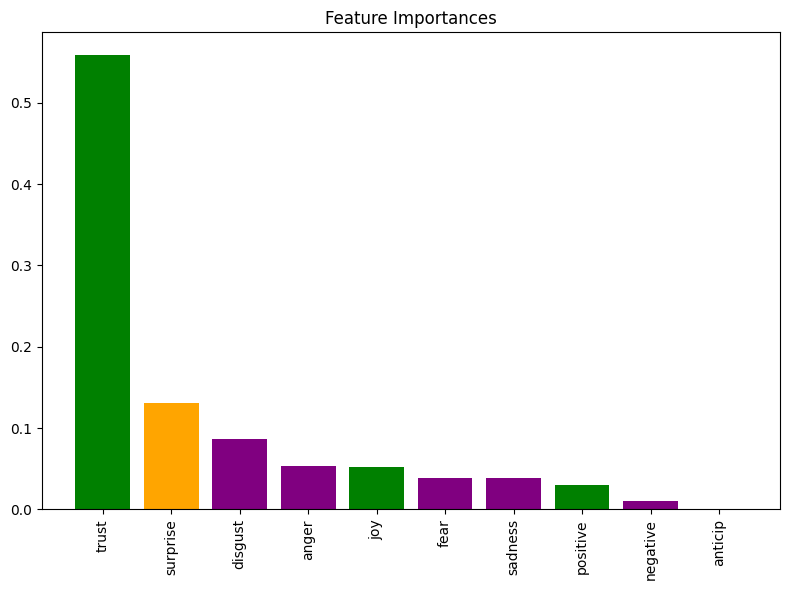

MAE (train): 25.638747323056016
MAE (test): 21.739560846598366


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(emotions_df, y, test_size=0.1, random_state=42)

# define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [300],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': [10]
}

# initialize random forest regressor
rf = RandomForestRegressor(random_state=42)

# perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1,scoring ='neg_mean_absolute_error',verbose=3)

# fit the grid search to the training data
grid_search.fit(X_train, y_train)

# get best hyperparameters
best_params = grid_search.best_params_

# initialize random forest regressor with best hyperparameters
rf_model = RandomForestRegressor(**best_params, random_state=42)

# Fit the model with the training data
rf_model.fit(X_train, y_train)

# Get the feature importances and corresponding feature names
importances = rf_model.feature_importances_
feature_names = emotions_df.columns

# Define a list of colors for the bars
colors = ['green', 'red', 'blue', 'orange', 'purple', 'yellow']

# Define the color for each feature
color_dict = {
    'trust': colors[0],
    'joy': colors[0],
    'disgust': colors[4],
    'sadness': colors[4],
    'anger': colors[4],
    'fear': colors[4],
    'positive':colors[0],
    'negative':colors[4],
    'surprise':colors[3],
    'anticip':colors[3]
}

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")

# Assign colors to the bars based on feature names
for i in range(len(indices)):
    color = color_dict[feature_names[indices[i]]]
    plt.bar(i, importances[indices[i]], color=color)

plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Predict the comment score for the test data
y_pred = rf_model.predict(X_test)

# Compute the mean squared error of the model on the training and testing data
train_mae1 = mean_absolute_error(y_train, rf_model.predict(X_train))
test_mae1 = mean_absolute_error(y_test, y_pred)
print("MAE (train):", train_mae1)
print("MAE (test):",test_mae1)



In [55]:
from prettytable import PrettyTable

# Define the column names and add them to the table
table = PrettyTable()
table.field_names = ["MAE (train)", "MAE (test)"]

# Add the row values to the table
table.add_row([train_mae1, test_mae1])
table.add_row([train_mae, test_mae])

# Print the table
print(table)


+--------------------+--------------------+
|    MAE (train)     |     MAE (test)     |
+--------------------+--------------------+
| 25.638747323056016 | 21.739560846598366 |
| 25.638747323056016 | 21.739560846598366 |
+--------------------+--------------------+


In [252]:
pd.DataFrame(y.describe())

,comment_score
count,695.000000
mean,19.014388
std,274.109945
min,-18.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,6714.000000


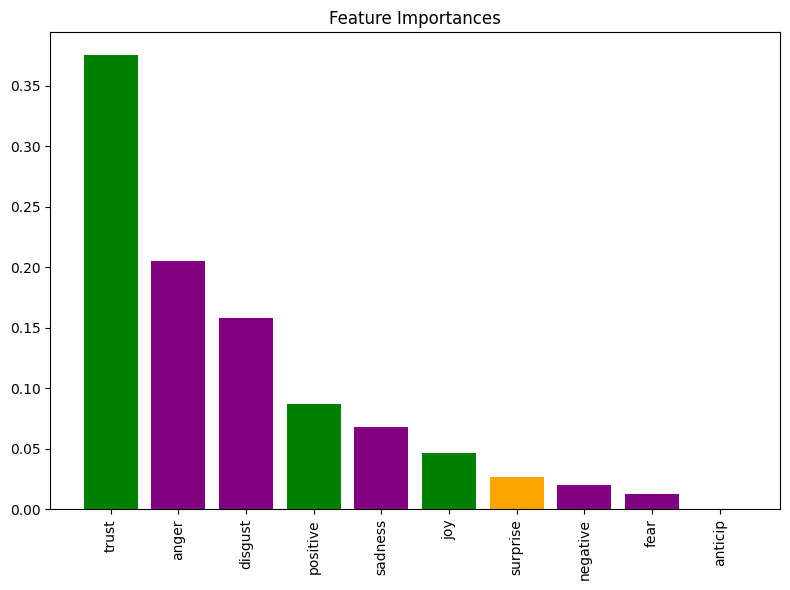

In [311]:
import matplotlib.pyplot as plt

# Get the feature importances and corresponding feature names
importances = permutation_importances(rf_model, X_train, y_train, mean_absolute_error)
importances = np.abs(importances)
importances= importances / np.sum(importances)
feature_names = X_train.columns

# Define the color for each feature
color_dict = {
    'trust': 'green',
    'joy': 'green',
    'disgust': 'purple',
    'sadness': 'purple',
    'anger': 'purple',
    'fear': 'purple',
    'positive':'green',
    'negative':'purple',
    'surprise':'orange',
    'anticip':'orange'
}

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")

# Assign colors to the bars based on feature names
for i in range(len(indices)):
    color = color_dict.get(feature_names[indices[i]], 'blue')
    plt.bar(i, importances[indices[i]], color=color)

plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()



### EXTRA.1) LDA IMPLEMENTATION 

#### A) PREPROCESS FOR LDA AND DEFINING FUNCTIONS

In [29]:
import nltk
import numpy as np
import gensim
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/Ramon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
corp = [nltk.word_tokenize(text) for text in Texts]
dictionary = gensim.corpora.Dictionary(corp)

# Filter out words that occur less than 10 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.3)

# Bow vector for lda
bow = [dictionary.doc2bow(line) for line in corp]

In [32]:
import matplotlib as plt

def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()
    
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha=0.8, per_word_topics=True)
    # visuzlize the model term topics
    #viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=8)]))
    if print_dist:
        # display the topic probabilities for each document
        doc_topics_list = []
        for idx, (line,bag) in enumerate(zip(Texts,bow)):
            doc_topics = model.get_document_topics(bag)
            doc_topics_list.append({'document': idx, 'probabilities': dict(doc_topics)})
            print('{}: {}'.format(idx, doc_topics))
    return model, doc_topics_list

#### B) Visualizing Topic proportions (without priors)

In [36]:
topic_proportions, doc_topics_list = test_eta('auto', dictionary, ntopics=6)
for doc_topics in doc_topics_list:
        print(doc_topics['document'], doc_topics['probabilities'])

Perplexity: -5.83
Topic 0: ['right', 'republican', 'hate', 'white', 'work', 'racist', 'though', 'take']
Topic 1: ['country', 'china', 'change', 'bad', 'politics', 'action', 'political', 'power']
Topic 2: ['tax', 'american', 'job', 'administration', 'US', 'state', 'policy', 'cut']
Topic 3: ['positive', 'obama', 'impact', 'presidency', 'government', 'economy', 'best', 'real']
Topic 4: ['signed', 'bill', 'trade', 'order', 'reform', 'million', 'drug', 'funding']
Topic 5: ['war', 'peace', 'korea', 'israel', 'military', 'news', 'troop', 'UAE']
0: [(0, 0.16668816), (1, 0.07408032), (2, 0.074081376), (3, 0.07408227), (4, 0.5369847), (5, 0.07408316)]
1: [(0, 0.041468564), (1, 0.14756416), (2, 0.3480925), (3, 0.0384715), (4, 0.05553686), (5, 0.36886644)]
2: [(0, 0.28572804), (1, 0.10714374), (2, 0.22617964), (3, 0.10715846), (4, 0.052565385), (5, 0.2212247)]
3: [(0, 0.059101976), (1, 0.22601911), (2, 0.07391976), (3, 0.21574782), (4, 0.27716133), (5, 0.14805001)]
4: [(0, 0.04263228), (1, 0.01950

In [78]:
data = []
for i, doc_topics in enumerate(doc_topics_list):
    row = {'document': i}
    for topic, prob in doc_topics['probabilities'].items():
        row[f'topic_{topic+1}'] = prob
    data.append(row)

df_reg = pd.DataFrame(data)

In [79]:
# Visualize some examples
for i in range(5,8,1):
    print(f"\033[1mDocument {i}:\033[0m {df.body[i]}")
    topic_props = df_reg.iloc[i, 1:].tolist()
    print(f"\033[1mTopic proportions:\033[0m {topic_props}")
    print()

Document 5: He fully funded the Land and Water Conservation Fund in perpetuity, as well as funded nearly all of the necessary backlog repair work for the national parks. Look up the Great American Outdoors Act. I have more, but I believe this disproves your claim.


Topic proportions: [0.1966249793767929, 0.06428276747465134, 0.30880528688430786, 0.05798342451453209, 0.302673876285553, 0.06962966918945312]

Document 6: He did make a difference when it comes to defence spending in Europe, which is now slowly climbing upwards for the first time since 1991. Now, whether that is beneficial or not is subjective, but I do think it qualifies as him successfully achieving a political goal. Regards
Topic proportions: [0.13793624937534332, 0.3014765679836273, 0.137935072183609, 0.13793569803237915, 0.14678028225898743, 0.13793613016605377]

Document 7: The one huge lasting positive impact on the USA that Donald Trump has had that I see is that his presidency has given truth to the thing parents 

#### C) Visualizing Topic proportions (with priors)

In [ ]:
import numpy as np

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

apriori_original = {
    'war':0,'peace':0,'military':0,
    'tax':1,'cut':1,'business':1, 
    'economy':2, 'employment':2, 'growth':2, 'unemployment':2,
    'virus':3, 'pandemic':3, 'virus':3,'coronavirus':3,
    'media':4, 'news':4
}

eta = create_eta(apriori_original, dictionary, 5)
test_eta(eta, dictionary, 5)

### EXTRA.2) LOGISTIC REGRESSION

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

nan_indices = df_reg.index[df_reg.isna().any(axis=1) | polarities_df.isna().any(axis=1)]
df_reg = df_reg.drop(nan_indices)
polarities_df = polarities_df.drop(nan_indices)


# # define X and y variables
X = pd.DataFrame(df_reg.values)
X = X.rename(columns={0: "topic 1", 1: "topic 2", 2: "topic 3", 3: "topic 4", 4: "topic 5", 5: "topic 6"})
y = pd.DataFrame(polarities_df.values)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


,0
count,575.000000
mean,0.537227
std,0.114140
min,0.000000
25%,0.500000
50%,0.523891
75%,0.597687
max,1.000000


In [84]:
# fit logistic regression model on the training set
model = sm.Logit(y_train, X_train).fit()

# print model summary
print(model.summary())

# predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate the Pseudo R-squared value using pandas
df = pd.DataFrame({'y_true': y_test.iloc[:,0], 'y_pred': y_pred})
#df['resid'] = df['y_true'] - df['y_pred']
#df['resid_sq'] = df['resid'] ** 2

#null_deviance = sum((y_test - y_test.mean()) ** 2)
##print(null_deviance)
#model_deviance = sum((y_test - y_pred) ** 2)
#pseudo_r2 = 1 - (model_deviance / null_deviance)

pseudo_r2 = 1 - (model.llf/ model.llnull)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# print performance metrics
print("Pseudo R-squared value:", pseudo_r2)
print('Mean absolute error: {:.4f}'.format(mae))
print('Mean squared error: {:.4f}'.format(mse))

Optimization terminated successfully.
         Current function value: 0.686441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:                  575
Model:                          Logit   Df Residuals:                      568
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                -0.07297
Time:                        19:34:14   Log-Likelihood:                -394.70
converged:                       True   LL-Null:                       -367.86
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
topic 1    -5.932e-05      0.000     -0.144      0.885      -0.001       0.001
topic 2       -0.3093      0.